# Cryptocurrency Price Prediction

### Modules used in this assignment

In [9]:
# essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# feature selection
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.feature_selection import RFE
# classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.neural_network import MLPClassifier as NN
# regression
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.neighbors import KNeighborsRegressor as kNNR
from sklearn.neural_network import MLPRegressor as NNR
# model selection, preprocessing, utils, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut as LOO
from sklearn.model_selection import KFold as KF
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

### Dataset

In [10]:
"""# which dataset?
to_test = 'bitcoin-day'

# dataset selection
nm = ['bitcoin-day','bitcoin-min']
opt = nm.index(to_test)
# format:  ['filepath','num_features','attribute_to_predict']
options = [['cryptocurrencypricehistory/bitcoin_dataset.csv',27,'price_increases'],['bitcoin-historical-data/btc-30min.csv',8,'price_increases_30']]

# filename
f = options[opt][0]
# features available
num_feats = options[opt][1]
# prediction attribute
attribute = options[opt][2]
"""
opt = 0
f = 'data/ripple_price.csv'
num_feats = 24
attribute = 'increase_flag'

# load file
data = pd.read_csv(f)
# features
names = list(data.columns.values)
names = names[1:len(names)]

# label encoding
if opt == 1:
    data = data.apply(LabelEncoder().fit_transform)

# split targets from attributes
X = data.iloc[:,1:num_feats]
Y = data[attribute]

In [11]:
print("Binary Classification:  Preliminaries\n-------------------------------------")
print("The price rises %.2f%% of the time and falls %.2f%% of the time" % (np.sum(Y)/float(len(Y))*100,(1-np.sum(Y)/float(len(Y)))*100))
print("If we predict the price will fall every single day, our accuracy will be %.2f%%" % ((1-np.sum(Y)/float(len(Y)))*100))

Binary Classification:  Preliminaries
-------------------------------------
The price rises 44.48% of the time and falls 55.52% of the time
If we predict the price will fall every single day, our accuracy will be 55.52%


### Feature Selection

First, we use a model _not_ being evaluated in this assigment to visualize feature importance.

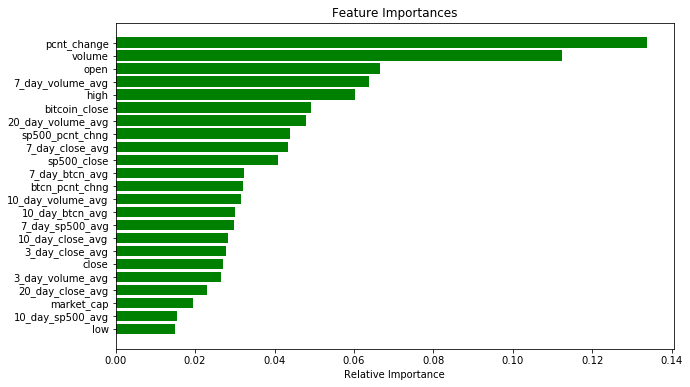

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# estimator
estimator = GB(n_estimators=200, learning_rate=0.001, max_depth=8, random_state=5)
estimator.fit(X_train, Y_train)

# plot feature importance
features = data.columns[1:num_feats]
importances = estimator.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Next, we use recursive feature elimination to reduce the number of attributes from 24 to 12.  We transform X, the input attributes, to reflect this choice.

In [13]:
# RFE using estimator defined above
selector = RFE(estimator, 12, step=1) # recursive feature elimination
selector = selector.fit(X_train, Y_train)
print(selector.ranking_) # value at [i] represents the importance of the given feature

X_reduced = selector.transform(X) # truncate the feature set

[ 1  1 12  1  1 10  1  1  1  1  1  5  2  1  8  4  6  1  7  9  1 11  3]


In [14]:
# returns indices of array elements matching a specified value
def find(lst, val):
    return [i for i, x in enumerate(lst) if x==val]
# list the features selected for use in our evaluation
feats_idx = find(list(selector.ranking_),1) # indices of top features
selected_feats = features[feats_idx]
print("Selected Features:")
print(list(selected_feats))

print("\nData Shape")
print(X_reduced.shape)

Selected Features:
['open', 'high', 'close', 'volume', 'pcnt_change', '3_day_volume_avg', '7_day_volume_avg', '10_day_volume_avg', '20_day_volume_avg', '10_day_close_avg', '10_day_btcn_avg', '7_day_sp500_avg']

Data Shape
(1376, 12)


## CLASSIFICATION

### Random Forest

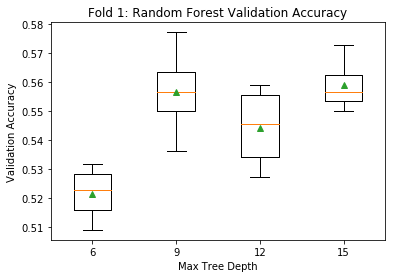

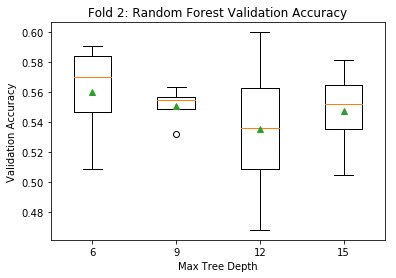

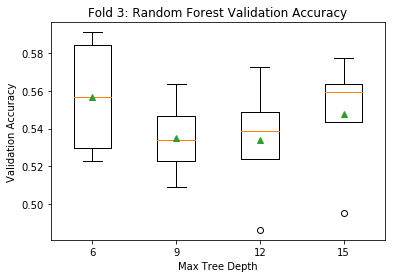

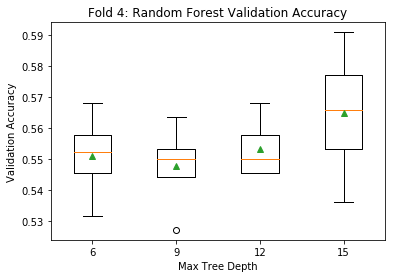

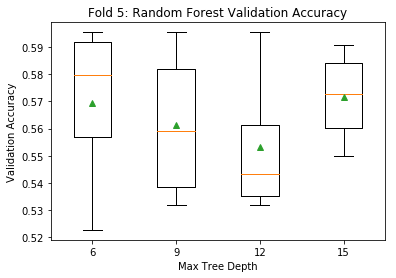


Fold	MCC	Accuracy
----	---	--------
1	0.129	56.82
2	0.052	53.18
3	0.161	59.55
4	0.187	61.36
5	0.167	58.64

Average test accuracy = 57.91%
Confusion Matrix
[[99 57]
 [65 55]]


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
rf_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = RF(n_jobs=4,n_estimators=40,max_depth=6,class_weight='balanced').fit(xxtrain, yytrain)
        model_2 = RF(n_jobs=4,n_estimators=40,max_depth=9,class_weight='balanced').fit(xxtrain, yytrain)
        model_3 = RF(n_jobs=4,n_estimators=40,max_depth=12,class_weight='balanced').fit(xxtrain, yytrain)
        model_4 = RF(n_jobs=4,n_estimators=40,max_depth=15,class_weight='balanced').fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['6','9','12','15']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d: Random Forest Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    rf_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],rf_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(rf_test_scores) * 100))

# outermost test set
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Adaboost

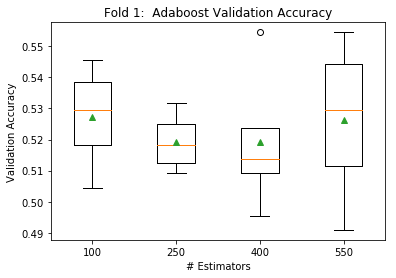

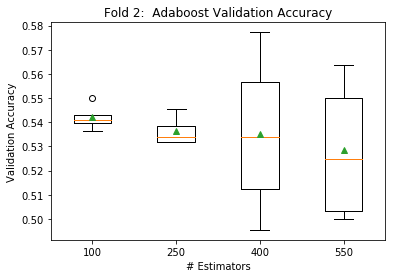

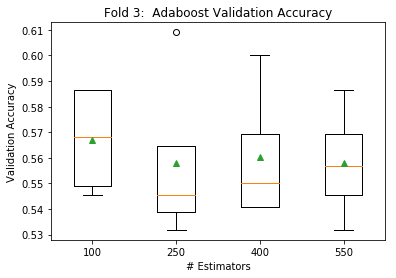

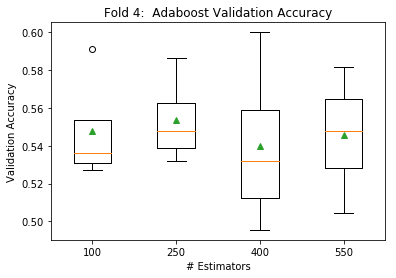

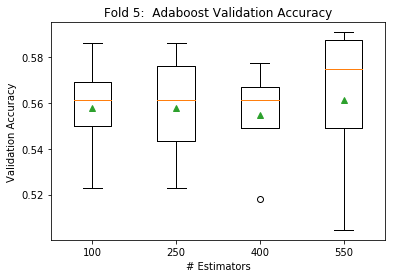


Fold	MCC	Accuracy
----	---	--------
1	0.135	58.64
2	0.071	56.36
3	0.073	55.91
4	0.066	55.00
5	0.104	55.91

Average test accuracy = 56.36%
Confusion Matrix
[[87 52]
 [86 51]]


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
ab_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = AB(n_estimators=100).fit(xxtrain, yytrain)
        model_2 = AB(n_estimators=250).fit(xxtrain, yytrain)
        model_3 = AB(n_estimators=400).fit(xxtrain, yytrain)
        model_4 = AB(n_estimators=550).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation score for each model in this fold
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    # boxplot of validation scores
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['100','250','400','550']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("# Estimators")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  Adaboost Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    ab_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],ab_test_scores[i]*100))

# overall test accuracy
print("\nAverage test accuracy = %.2f%%" % (np.mean(ab_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Decision Tree

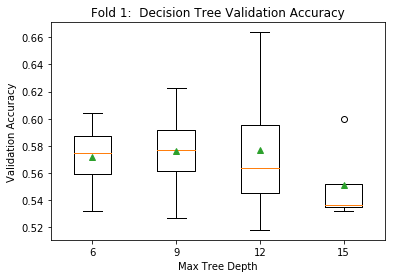

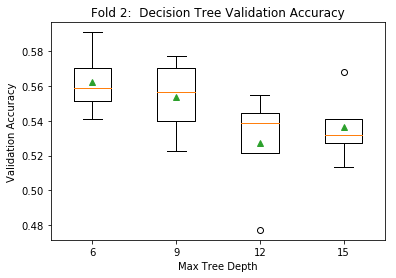

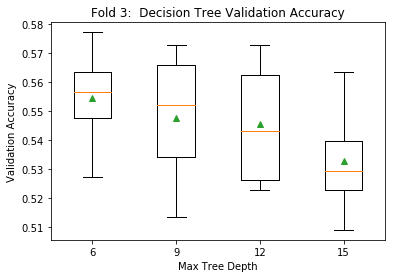

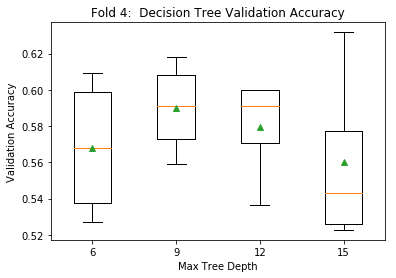

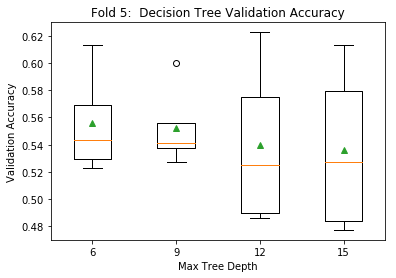


Fold	MCC	Accuracy
----	---	--------
1	-0.049	50.00
2	0.026	51.82
3	0.037	55.45
4	0.052	57.27
5	0.060	54.09

Average test accuracy = 53.73%
Confusion Matrix
[[95 44]
 [77 60]]


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
dt_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = DT(max_depth=6,criterion='entropy').fit(xxtrain, yytrain)
        model_2 = DT(max_depth=9,criterion='entropy').fit(xxtrain, yytrain)
        model_3 = DT(max_depth=12,criterion='entropy').fit(xxtrain, yytrain)
        model_4 = DT(max_depth=15,criterion='entropy').fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['6','9','12','15']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  Decision Tree Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    dt_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],dt_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(dt_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### MLP

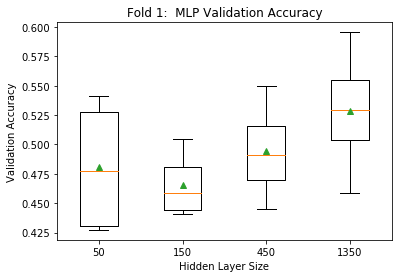

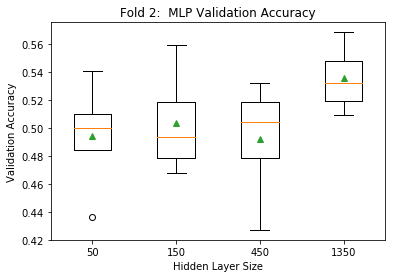

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


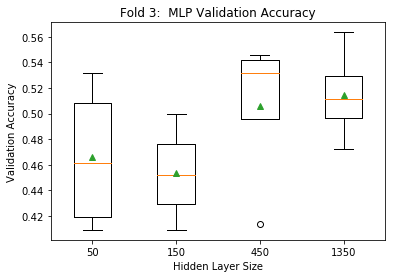

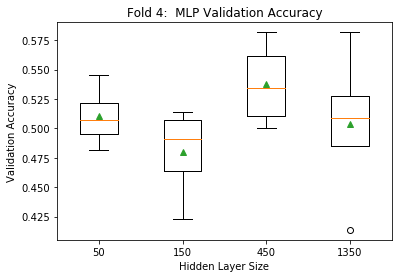

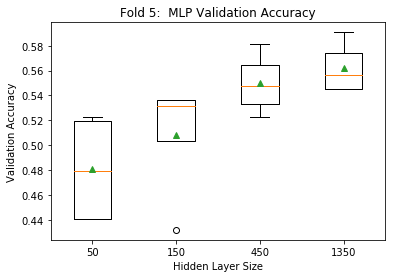


Fold	MCC	Accuracy
----	---	--------
1	-0.033	56.82
2	0.000	54.55
3	0.127	59.09
4	-0.123	43.64
5	0.063	53.18

Average test accuracy = 53.45%
Confusion Matrix
[[151   1]
 [122   2]]


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
nn_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = NN(solver='adam',hidden_layer_sizes=(50,)).fit(xxtrain, yytrain)
        model_2 = NN(solver='adam',hidden_layer_sizes=(150,)).fit(xxtrain, yytrain)
        model_3 = NN(solver='adam',hidden_layer_sizes=(450,)).fit(xxtrain, yytrain)
        model_4 = NN(solver='adam',hidden_layer_sizes=(1350,)).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['50','150','450','1350']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  MLP Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    nn_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],nn_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(nn_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### k-Nearest Neighbor

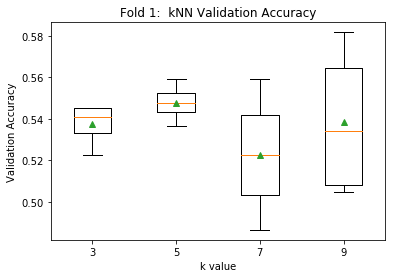

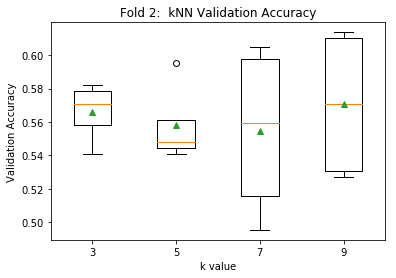

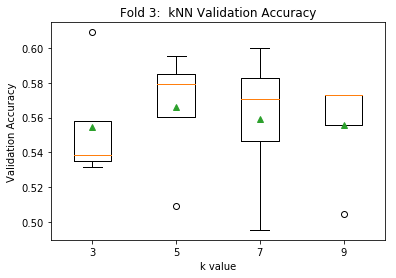

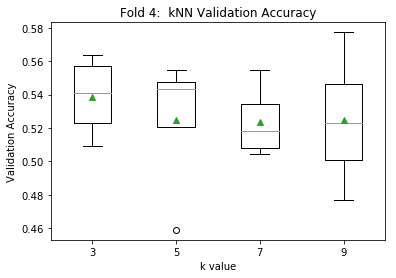

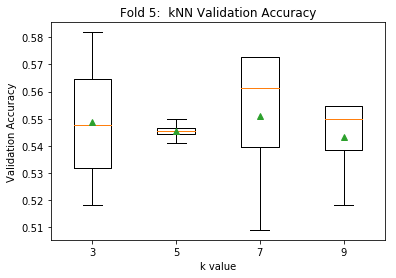


Fold	MCC	Accuracy
----	---	--------
1	0.021	55.00
2	0.079	54.55
3	0.049	54.09
4	-0.004	51.82
5	0.022	52.73

Average test accuracy = 53.64%
Confusion Matrix
[[95 41]
 [97 43]]


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.2)


fold = 0
kf1 = KF(n_splits=5)
knn_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = kNN(n_neighbors=3).fit(xxtrain, yytrain)
        model_2 = kNN(n_neighbors=5).fit(xxtrain, yytrain)
        model_3 = kNN(n_neighbors=7).fit(xxtrain, yytrain)
        model_4 = kNN(n_neighbors=9).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['3','5','7','9']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("k value")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  kNN Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    knn_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],knn_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(knn_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Data Visualization

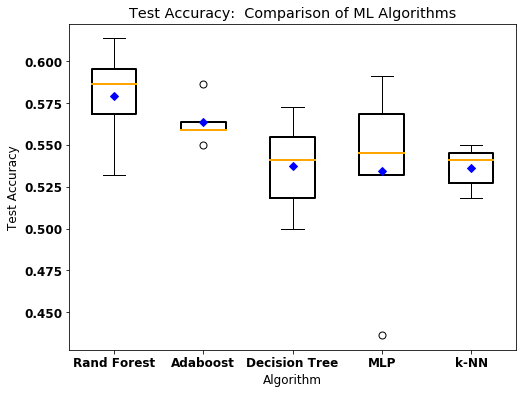

In [20]:
# overall test data
boxdata = [rf_test_scores, ab_test_scores, dt_test_scores, nn_test_scores, knn_test_scores]
labels = ['Rand Forest','Adaboost','Decision Tree','MLP','k-NN']
title = "Test Accuracy:  Comparison of ML Algorithms"

#formatting
font = {'size'   : 12, 'weight':'bold'}
plt.rc('font', **font)
boxprops = dict(linewidth=2, color='black')
flierprops = dict(marker='o', markeredgecolor='black',markerfacecolor='white', markersize=7, linestyle='none')
medianprops = dict(linestyle='-', linewidth=2, color='orange')
meanpointprops = dict(marker='D', markeredgecolor='blue', markerfacecolor='blue')

# boxplot
plt.figure(figsize=(8,6))
plt.boxplot(boxdata,labels=labels,showmeans=True,boxprops=boxprops,medianprops=medianprops,flierprops=flierprops, meanprops=meanpointprops)
plt.xlabel("Algorithm")
plt.ylabel("Test Accuracy")
plt.title(title)
plt.show()

## REGRESSION

### Dataset

In [21]:
# which dataset?
"""to_test = 'bitcoin-day'

# dataset selection
nm = ['bitcoin-day','bitcoin-min']
opt = nm.index(to_test)
# format:  ['filepath','num_features','attribute_to_predict']
options = [['cryptocurrencypricehistory/bitcoin_dataset.csv',27,'tomorrow_price'],['bitcoin-historical-data/btc-30min.csv',8,'price_increases_30']]

# filename
f = options[opt][0]
# features available
num_feats = options[opt][1]
# prediction attribute
attribute = options[opt][2]
"""
# np.seterr(divide='ignore')

opt = 0
f = 'data/ripple_price.csv'
num_feats = 24
attribute = 'tomorrow_price'

# load file
data = pd.read_csv(f)
# features
names = list(data.columns.values)
names = names[1:len(names)]

# label encoding
if opt == 1:
    data = data.apply(LabelEncoder().fit_transform)

# split targets from attributes
to_use = []
X_data = data.iloc[:,1:num_feats]
Y_data = data[attribute]

### Random Forest



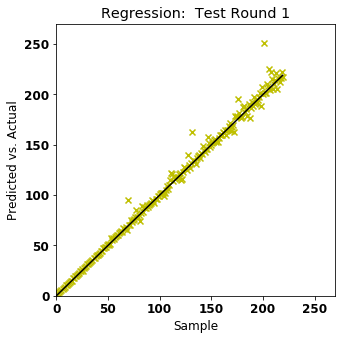

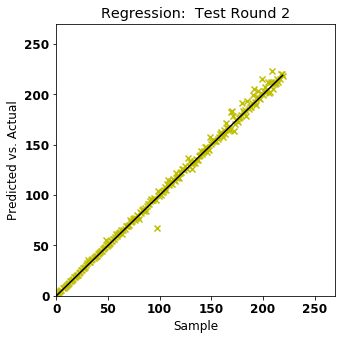

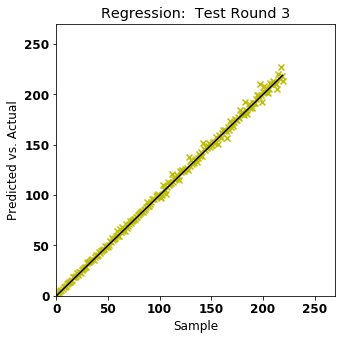

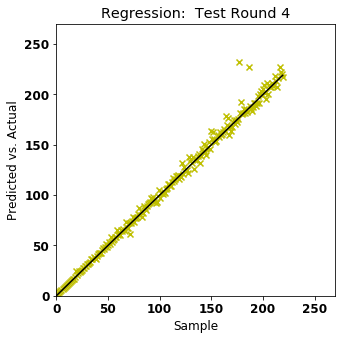

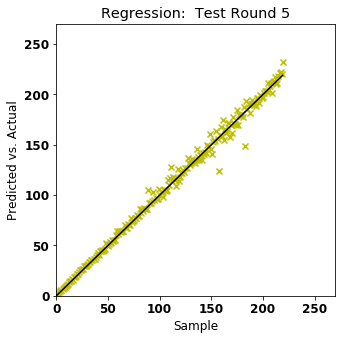


Fold	MSE	R^2 val.
----	---	--------
1	0.000	99.88
2	0.000	99.90
3	0.000	99.94
4	0.000	99.62
5	0.000	99.83

Average R^2 = 99.83%


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y_data), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
rfr_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    mses = []
    mse1 = []
    mse2 = []
    mse3 = []
    mse4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = RFR(n_jobs=4,n_estimators=400,max_depth=6).fit(xxtrain, yytrain)
        model_2 = RFR(n_jobs=4,n_estimators=400,max_depth=9).fit(xxtrain, yytrain)
        model_3 = RFR(n_jobs=4,n_estimators=400,max_depth=12).fit(xxtrain, yytrain)
        model_4 = RFR(n_jobs=4,n_estimators=400,max_depth=15).fit(xxtrain, yytrain)
        # R^2 values
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        # MSE
        mse1.append(mean_squared_error(yyval, model_1.predict(xxval)))
        mse2.append(mean_squared_error(yyval, model_2.predict(xxval)))
        mse3.append(mean_squared_error(yyval, model_3.predict(xxval)))
        mse4.append(mean_squared_error(yyval, model_4.predict(xxval)))
        models = [model_1, model_2, model_3, model_4]
    
    # average R^2 for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    mses = [np.mean(mse1), np.mean(mse2), np.mean(mse3), np.mean(mse4)]
    
    # pick model with best R^2 and use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]

    # plot
    preds = model.predict(xtest)
    axes = range(1,len(preds)+1)
    regression = np.array(preds/ytest) * axes
    plt.figure(figsize=(5, 5))
    plt.title('Regression:  Test Round %d' % fold)
    plt.scatter(np.arange(0,len(regression),1), regression, c='y',marker='x')
    plt.plot(np.arange(0,len(regression),1),np.arange(0,len(regression),1),c='k')
    plt.axis([0,len(regression)+50,0,len(regression)+50])
    plt.xlabel('Sample')
    plt.ylabel('Predicted vs. Actual')
    plt.show()
    
    # R^2 for this fold
    rfr_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mean_squared_error(ytest, model.predict(xtest)))

print("\nFold\tMSE\tR^2 val.\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],rfr_test_scores[i]*100))

# results of each testing phase
print("\nAverage R^2 = %.2f%%" % (np.mean(rfr_test_scores) * 100))

### Adaboost

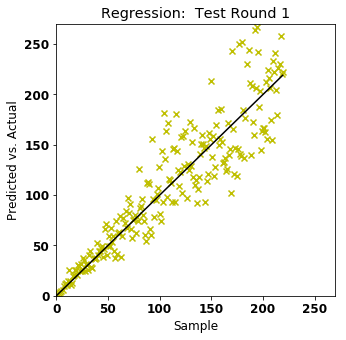

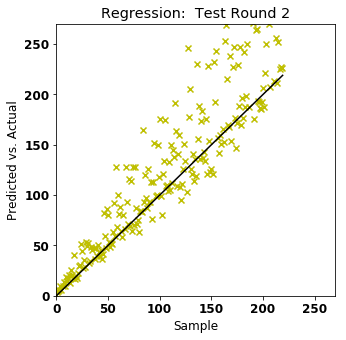

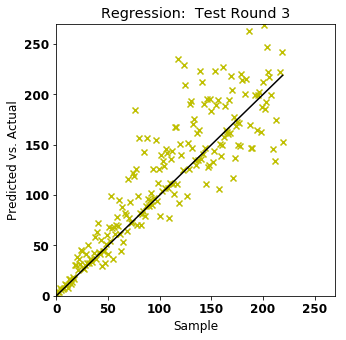

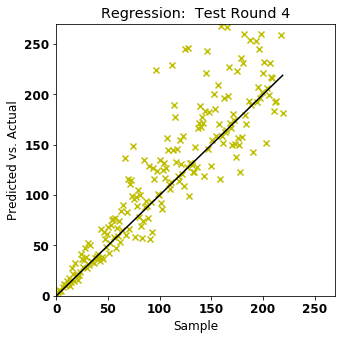

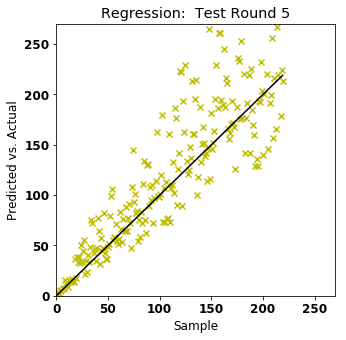


Fold	MSE	R^2 val.
----	---	--------
1	0.000	99.45
2	0.000	99.74
3	0.000	99.71
4	0.000	99.71
5	0.000	99.53

Average R^2 = 99.63%


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y_data), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
abr_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    mses = []
    mse1 = []
    mse2 = []
    mse3 = []
    mse4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = ABR(n_estimators=100).fit(xxtrain, yytrain)
        model_2 = ABR(n_estimators=200).fit(xxtrain, yytrain)
        model_3 = ABR(n_estimators=300).fit(xxtrain, yytrain)
        model_4 = ABR(n_estimators=400).fit(xxtrain, yytrain)
        # R^2 values
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        # MSE
        mse1.append(mean_squared_error(yyval, model_1.predict(xxval)))
        mse2.append(mean_squared_error(yyval, model_2.predict(xxval)))
        mse3.append(mean_squared_error(yyval, model_3.predict(xxval)))
        mse4.append(mean_squared_error(yyval, model_4.predict(xxval)))
        models = [model_1, model_2, model_3, model_4]
    
    # average R^2 for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    mses = [np.mean(mse1), np.mean(mse2), np.mean(mse3), np.mean(mse4)]
    
    # pick model with best R^2 and use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]

    # plot
    preds = model.predict(xtest)
    axes = range(1,len(preds)+1)
    regression = np.array(preds/ytest) * axes
    plt.figure(figsize=(5, 5))
    plt.title('Regression:  Test Round %d' % fold)
    plt.scatter(np.arange(0,len(regression),1), regression, c='y',marker='x')
    plt.plot(np.arange(0,len(regression),1),np.arange(0,len(regression),1),c='k')
    plt.axis([0,len(regression)+50,0,len(regression)+50])
    plt.xlabel('Sample')
    plt.ylabel('Predicted vs. Actual')
    plt.show()
    
    # R^2 for this fold
    abr_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mean_squared_error(ytest, model.predict(xtest)))

print("\nFold\tMSE\tR^2 val.\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],abr_test_scores[i]*100))

# results of each testing phase
print("\nAverage R^2 = %.2f%%" % (np.mean(abr_test_scores) * 100))

### Decision Tree

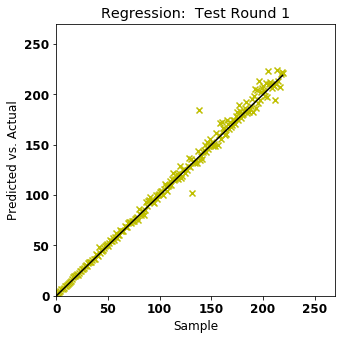

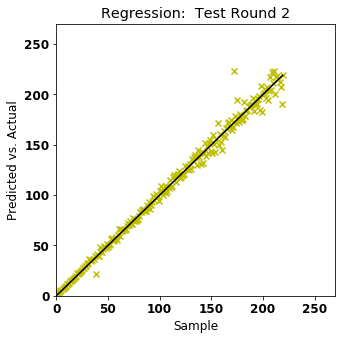

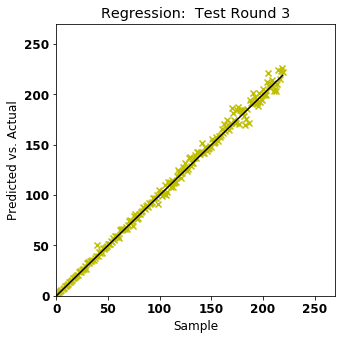

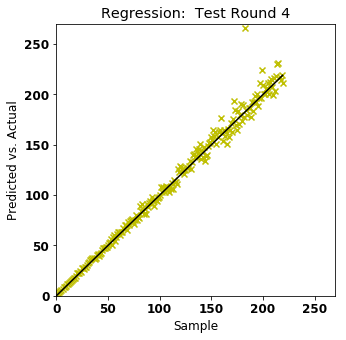

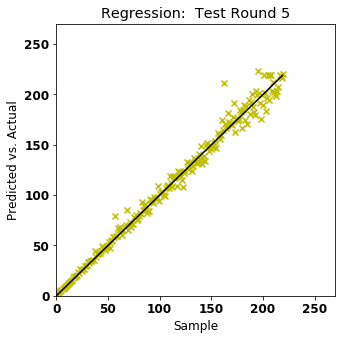


Fold	MSE	R^2 val.
----	---	--------
1	0.000	99.83
2	0.000	99.71
3	0.000	99.94
4	0.000	99.93
5	0.000	99.74

Average R^2 = 99.83%


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y_data), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
dtr_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    mses = []
    mse1 = []
    mse2 = []
    mse3 = []
    mse4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = DTR(max_depth=6).fit(xxtrain, yytrain)
        model_2 = DTR(max_depth=9).fit(xxtrain, yytrain)
        model_3 = DTR(max_depth=12).fit(xxtrain, yytrain)
        model_4 = DTR(max_depth=15).fit(xxtrain, yytrain)
        # R^2 values
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        # MSE
        mse1.append(mean_squared_error(yyval, model_1.predict(xxval)))
        mse2.append(mean_squared_error(yyval, model_2.predict(xxval)))
        mse3.append(mean_squared_error(yyval, model_3.predict(xxval)))
        mse4.append(mean_squared_error(yyval, model_4.predict(xxval)))
        models = [model_1, model_2, model_3, model_4]
    
    # average R^2 for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    mses = [np.mean(mse1), np.mean(mse2), np.mean(mse3), np.mean(mse4)]
    
    # pick model with best R^2 and use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]

    # plot
    preds = model.predict(xtest)
    axes = range(1,len(preds)+1)
    regression = np.array(preds/ytest) * axes
    plt.figure(figsize=(5, 5))
    plt.title('Regression:  Test Round %d' % fold)
    plt.scatter(np.arange(0,len(regression),1), regression, c='y',marker='x')
    plt.plot(np.arange(0,len(regression),1),np.arange(0,len(regression),1),c='k')
    plt.axis([0,len(regression)+50,0,len(regression)+50])
    plt.xlabel('Sample')
    plt.ylabel('Predicted vs. Actual')
    plt.show()
    
    # R^2 for this fold
    dtr_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mean_squared_error(ytest, model.predict(xtest)))

print("\nFold\tMSE\tR^2 val.\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],dtr_test_scores[i]*100))

# results of each testing phase
print("\nAverage R^2 = %.2f%%" % (np.mean(dtr_test_scores) * 100))

### k-Nearest Neighbor

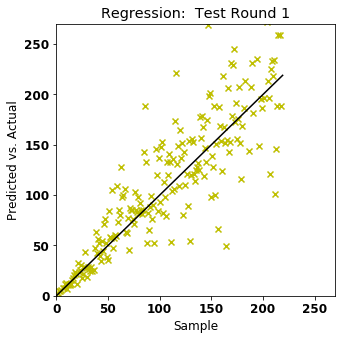

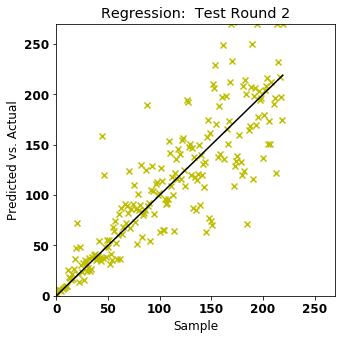

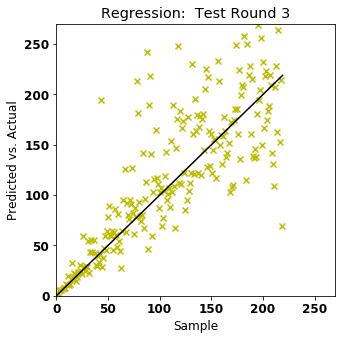

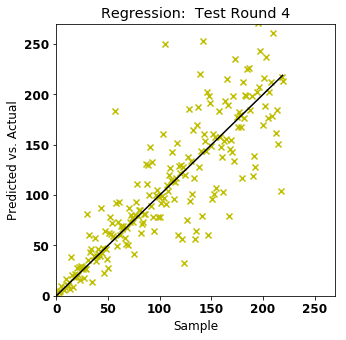

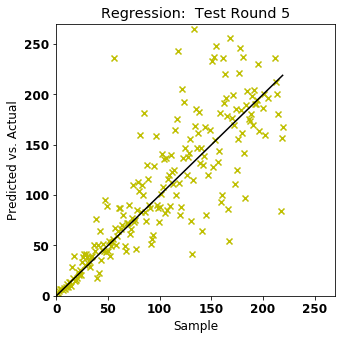


Fold	MSE	R^2 val.
----	---	--------
1	0.000	94.82
2	0.000	94.63
3	0.000	95.09
4	0.000	95.25
5	0.000	95.08

Average R^2 = 94.97%


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y_data), test_size=0.2)

fold = 0
kf1 = KF(n_splits=5)
knnr_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    mses = []
    mse1 = []
    mse2 = []
    mse3 = []
    mse4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = kNNR(n_neighbors=3).fit(xxtrain, yytrain)
        model_2 = kNNR(n_neighbors=5).fit(xxtrain, yytrain)
        model_3 = kNNR(n_neighbors=7).fit(xxtrain, yytrain)
        model_4 = kNNR(n_neighbors=9).fit(xxtrain, yytrain)
        # R^2 values
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        # MSE
        mse1.append(mean_squared_error(yyval, model_1.predict(xxval)))
        mse2.append(mean_squared_error(yyval, model_2.predict(xxval)))
        mse3.append(mean_squared_error(yyval, model_3.predict(xxval)))
        mse4.append(mean_squared_error(yyval, model_4.predict(xxval)))
        models = [model_1, model_2, model_3, model_4]
    
    # average R^2 for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    mses = [np.mean(mse1), np.mean(mse2), np.mean(mse3), np.mean(mse4)]
    
    # pick model with best R^2 and use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]

    # plot
    preds = model.predict(xtest)
    axes = range(1,len(preds)+1)
    regression = np.array(preds/ytest) * axes
    plt.figure(figsize=(5, 5))
    plt.title('Regression:  Test Round %d' % fold)
    plt.scatter(np.arange(0,len(regression),1), regression, c='y',marker='x')
    plt.plot(np.arange(0,len(regression),1),np.arange(0,len(regression),1),c='k')
    plt.axis([0,len(regression)+50,0,len(regression)+50])
    plt.xlabel('Sample')
    plt.ylabel('Predicted vs. Actual')
    plt.show()
    
    # R^2 for this fold
    knnr_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mean_squared_error(ytest, model.predict(xtest)))

print("\nFold\tMSE\tR^2 val.\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],knnr_test_scores[i]*100))

# results of each testing phase
print("\nAverage R^2 = %.2f%%" % (np.mean(knnr_test_scores) * 100))